# Interactive Occlusion Heatmap slider for all models

For a given patient id the occlusion heatmap is calculated for all models and displayed in a slider.
The size of the occlusion can be adjusted manually.

### Imports

In [1]:
%matplotlib inline
import os
import h5py
import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

print("TF  Version",tf.__version__)

TF  Version 2.2.0


Using TensorFlow backend.


In [2]:
# check and set path before loading modules
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
print(os.getcwd())

/tf/notebooks/schnemau/xAI_stroke_3d


In [3]:
import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat
import Utils_maurice as utils

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

In [4]:
import functions_model_definition as md
import functions_read_data as rdat
import functions_occlusion as oc
import functions_gradcam as gc
import functions_plot_heatmap as phm
import functions_slider as sl

### Load Data and Set Parameters

In [5]:
# Define the path + output path:
DATA_DIR = DIR + "data/"
version = "10Fold_CIBLSX" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

# Define Model Version
model_version = 1

In [6]:
WEIGHT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/"
DATA_OUTPUT_DIR = '/tf/notebooks/schnemau/xAI_stroke_3d/pictures/10Fold_CIBLSX/'
PIC_OUTPUT_DIR = '/tf/notebooks/schnemau/xAI_stroke_3d/pictures/10Fold_CIBLSX/'
pic_save_name = '10Fold_V0_M1_oc_predcl_CIBLSX'

In [7]:
#load tabular data
tabular_df = rdat.split_data_tabular_test()

In [8]:
def version_setup(DATA_DIR, version, model_version):
    # DATA_DIR: directory where data is stored
    # version: which data to use (e.g. 10Fold_sigmoid_V1)
    # model_version: which model version to use

    id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
    num_models = 5
    pat = id_tab["p_id"].to_numpy()
    X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
    path_results = DATA_DIR + "all_tab_results_" + version + "_M" + str(model_version) + "_dyn_threshold" + ".csv" # 10 Fold
    all_results = pd.read_csv(path_results, sep=",")
    all_results = all_results.sort_values("p_idx")
    return X_in, pat, id_tab, all_results, num_models

In [9]:
## load images and ids
(X_in, pat, id_tab, all_results, num_models) = version_setup(
    DATA_DIR = DATA_DIR, version = version, model_version = model_version)

## load patient data
PAT_CSV_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")
pat_dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia,iaty,ivty
0,101,1,"85,6",0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN
1,102,1,"66,7",1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN
2,103,0,"29,2",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,104,0,83,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,NaN,NaN
4,105,6,"89,2",0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,540,2,80,0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0
514,541,0,19,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1
515,542,1,68,1,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0
516,543,4,74,0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0


## Model

In [10]:
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X_in, 1)

input_dim = (128, 128, 28, 1)
output_dim = 1
batch_size = 6
C = 2 

mbl = utils.img_model_linear_final(input_dim, output_dim)
mls = utils.mod_linear_shift(X_tab_train.shape[1])
model_3d = ontram(mbl, mls)             

model_3d.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                loss=ontram_loss(C, batch_size),
                                metrics=[ontram_acc(C, batch_size)])

check_print = True

In [11]:
def set_generate_model_name(model_version, path):
    def generate_model_name(which_split, model_nr):

        return (path + "3d_cnn_binary_model_split" + "CIB_LSX" + str(which_split) + 
                "_normalized_avg_layer_paper_model_" + "linear" + 
                "_activation_"  + str(model_version) + "_" + str(model_nr) + ".h5")
        
            
    return generate_model_name

In [12]:
# Define Model Name
generate_model_name = set_generate_model_name(
    model_version = 1, 
    path = WEIGHT_DIR) 

# Occlusion without slider

In [13]:
all_results.reset_index().p_id[3]

5

In [25]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(
        [1], results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)

res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,205,1,1,1.0,0,val,train,train,train,train,...,0.004654,0.001761,0.002267,0.004139,0.003226,0.428448,0,0.001357,0.0,True


Two different occlusions are recommended.  
However, the occlusion can also be defined by the user. The third row of the following output must be all 0 and the fourth row must be True and the occlusion will work.

In [26]:
### occlusion
#occ_size = (14, 14, 10) #jonas
occ_size = (20, 20, 16)
occ_stride = 6
print("number of occlusions: ", int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)))
print("number of occlusions per axis: ", ((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)
print((np.asarray(res_images.shape[1:4]) - occ_size) % occ_stride) # all must be zero
print(all(np.array(occ_size) > occ_stride)) # must be true
print(np.array(res_images.shape[1:4]) / occ_size) # if all same, then same ratio of occ_size to image size

number of occlusions:  1083
number of occlusions per axis:  [19. 19.  3.]
[0 0 0]
True
[6.4  6.4  1.75]


In [27]:
import time

start = time.time()
(heatmap, resized_img, max_hm_slice, hm_mean_std) =  utils.volume_occlusion_tabular(
    volume = res_images, 
    res_tab = res_table, 
    tabular_df = tabular_df,
    occlusion_size = np.array(occ_size), 
    normalize = True,
    both_directions = False,
    invert_hm = "pred_class", 
    model_names = res_model_names[0][:], # select model
    occlusion_stride = occ_stride)

end = time.time()
print(end - start)

25.762167930603027


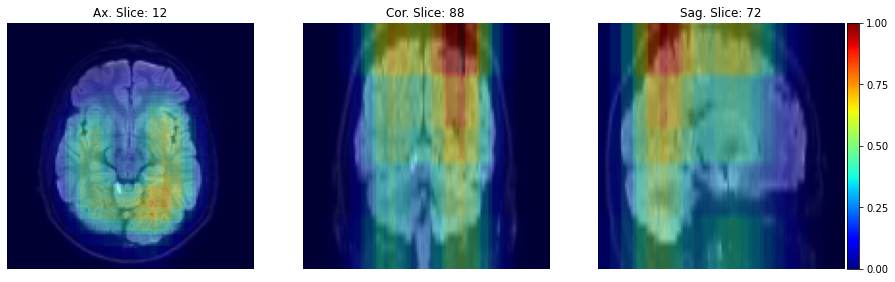

In [28]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

## Old, needs to be deleted

In [ ]:
import time

start = time.time()
(heatmap, resized_img, max_hm_slice, hm_mean_std) =  utils.volume_occlusion(
    volume = res_images, 
    res_tab = res_table, 
    occlusion_size = np.array(occ_size), 
    normalize = True,
    both_directions = False,
    invert_hm = "pred_class", 
    cnn = model_3d,
    model_names = res_model_names[0][:], # select model
    occlusion_stride = occ_stride)

end = time.time()
print(end - start)

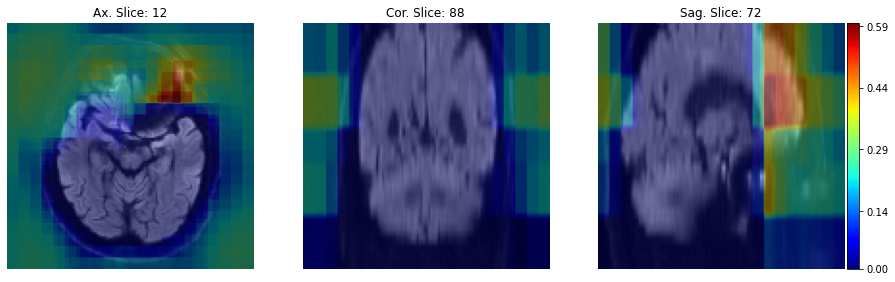

In [19]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

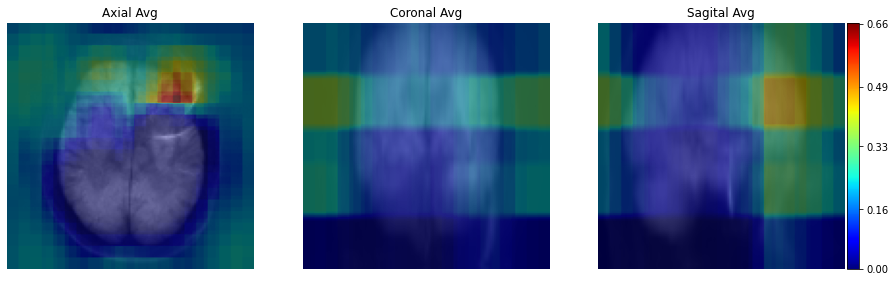

In [20]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "avg",
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

In [13]:
from importlib import reload
reload(utils)

<module 'Utils_maurice' from '/tf/notebooks/schnemau/xAI_stroke_3d/Utils_maurice.py'>

patient id:  33
age:  90
true mrs:  6.0
true class:  1
pred class: 1
pred prob (class 1):  0.24987069
Threshold:  0.16743733
pred uncertainty:  0.28639635
max slices: (10, 74, 62)


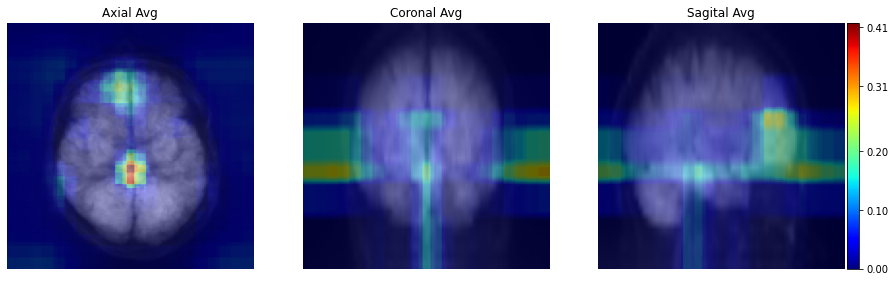

In [29]:
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6

utils.occlusion_interactive_plot(
    33, # patient id
    occ_size = occ_size, occ_stride = occ_stride,
    cnn=model_3d, all_results=all_results, pat=pat, X_in=X_in,
    generate_model_name=generate_model_name, num_models=num_models,
    pat_dat=pat_dat,
    pred_hm_only=True) # if True, only the heatmap for the predicted class is shown, otherwise also negative heatmaps are shown